In [ ]:
!pip3 install python-chess
!pip3 install cairosvg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import chess
import chess.svg
import cairosvg
from cairosvg import svg2png
from collections import OrderedDict
from operator import itemgetter 
import pandas as pd
import numpy as np
import tensorflow as tf
from IPython.display import clear_output
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
!git clone https://github.com/DeotaleChinmay2001/chess-engine-model.git

fatal: destination path 'chess-engine-model' already exists and is not an empty directory.


In [ ]:
path_to_model = '/content/chess-engine-model/latest-model'

global model
model = tf.saved_model.load(path_to_model)                                 # load saved model


def predict(df_eval, imported_model):
    """Return array of predictions for each row of df_eval
    
    Keyword arguments:
    df_eval -- pd.DataFrame
    imported_model -- tf.saved_model 
    """
    col_names = df_eval.columns                                                  
    dtypes = df_eval.dtypes
    predictions = []
    for row in df_eval.iterrows():
      example = tf.train.Example()
      for i in range(len(col_names)):
        dtype = dtypes[i]
        col_name = col_names[i]
        value = row[1][col_name]
        if dtype == 'object':
          value = bytes(value, 'utf-8')                                                # Necessary to convert all features in similar datatype
          example.features.feature[col_name].bytes_list.value.extend([value])
        elif dtype == 'float':
          example.features.feature[col_name].float_list.value.extend([value])
        elif dtype == 'int':
          example.features.feature[col_name].int64_list.value.extend([value])
      
      '''
      1) make prediction for every row
      2) convert the integer prediction into string
      3) Append into Predictions list.
      '''
      
      predictions.append(imported_model.signatures['predict'](examples = tf.constant([example.SerializeToString()])))            
    return predictions


def get_board_features(board):
    """Return array of features for a board
    
    Keyword arguments:
    board -- chess.Board()
    """
    board_features = []
    for square in chess.SQUARES:                                                
      board_features.append(str(board.piece_at(square)))                        # Get labelled feature of board (like "0 0 B r K Q 0 0")
    return board_features


def get_move_features(move):
    """Return 2 arrays of features for a move
    
    Keyword arguments:
    move -- chess.Move
    """
    from_ = np.zeros(64)                                                        # 1-d array of zeroes
    to_ = np.zeros(64)
    from_[move.from_square] = 1                                                 # from where the piece is moved is converted to 1
    to_[move.to_square] = 1                                                     # from where the piece is moved is converted to 1
    return from_, to_


def get_possible_moves_data(current_board):
    """Return pd.DataFrame of all possible moves used for predictions
    
    Keyword arguments:
    current_board -- chess.Board()
    """
    data = []                                                                                     # Empty List
    moves = list(current_board.legal_moves)                                                       # legal moves for current board
    for move in moves:                                                                            
      from_square, to_square = get_move_features(move)                                            # This will get the features of the move to be performed 
      row = np.concatenate((get_board_features(current_board), from_square, to_square))           # Concatenate features of board and moves 
      data.append(row)                                                                            # TO append all rows
    
    board_feature_names = chess.SQUARE_NAMES                                                      # returns list of square(position) names.
    move_from_feature_names = ['from_' + square for square in chess.SQUARE_NAMES]                 
    move_to_feature_names = ['to_' + square for square in chess.SQUARE_NAMES]
    
    columns = board_feature_names + move_from_feature_names + move_to_feature_names               # create column names 
    
    df = pd.DataFrame(data = data, columns = columns)                                             # create dataframe with heading

    for column in move_from_feature_names:                                                        
      df[column] = df[column].astype(float)                                                       # Convert in type float 
    for column in move_to_feature_names:
      df[column] = df[column].astype(float)
    return df


def find_best_moves(current_board, model, proportion = 0.5):
    """Return array of the best chess.Move
    
    Keyword arguments:
    current_board -- chess.Board()
    model -- tf.saved_model
    proportion -- proportion of best moves returned
    """
    moves = list(current_board.legal_moves)                                   # create a list of legal moves 
    df_eval = get_possible_moves_data(current_board)                          # pd.DataFrame of all possible moves used for predictions
    predictions = predict(df_eval, model)                                     # array of predictions for each row of df_eval                            
    good_move_probas = []                                                   
    
    for prediction in predictions:                                            
      proto_tensor = tf.make_tensor_proto(prediction['probabilities'])        # converts the numpy array to a tensor proto (necessary because model was trained on dictionary of tensor variable and not numpy arrays)
      proba = tf.make_ndarray(proto_tensor)[0][1]                             # Create a numpy ndarray with the same shape and data as the tensor. image. 
      good_move_probas.append(proba)                                          # append in the list
    
    dict_ = dict(zip(moves, good_move_probas))                                # create a dictionary of move as key and probability as value
    dict_ = OrderedDict(sorted(dict_.items(), key = itemgetter(1), reverse = True))        # sort the Dictionary based on value( probabilities )      
    
    best_moves = list(dict_.keys())                                           # create a list of moves based on decreasing order of probability of being good move
 
    return best_moves[0:int(len(best_moves)*proportion)]                      # return list of first x( in this case is 50% ) proportion of moves.

In [ ]:
pawn_white_eval = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                            [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0],
                            [1.0, 1.0, 2.0, 3.0, 3.0, 2.0, 1.0, 1.0],
                            [0.5, 0.5, 1.0, 2.5, 2.5, 1.0, 0.5, 0.5],
                            [0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0],
                            [0.5, -0.5, -1.0, 0.0, 0.0, -1.0, -0.5, 0.5],
                            [0.5, 1.0, 1.0, -2.0, -2.0, 1.0, 1.0, 0.5],
                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], np.float)

pawn_black_eval = pawn_white_eval[::-1]


knight_white_eval = np.array([[-5.0, -4.0, -3.0, -3.0, -3.0, -3.0, -4.0, -5.0],
                              [-4.0, -2.0, 0.0, 0.0, 0.0, 0.0, -2.0, -4.0],
                              [-3.0, 0.0, 1.0, 1.5, 1.5, 1.0, 0.0, -3.0],
                              [-3.0, 0.5, 1.5, 2.0, 2.0, 1.5, 0.5, -3.0],
                              [-3.0, 0.0, 1.5, 2.0, 2.0, 1.5, 0.0, -3.0],
                              [-3.0, 0.5, 1.0, 1.5, 1.5, 1.0, 0.5, -3.0],
                              [-4.0, -2.0, 0.0, 0.5, 0.5, 0.0, -2.0, -4.0],
                              [-5.0, -4.0, -3.0, -3.0, -3.0, -3.0, -4.0, -5.0]], np.float)

knight_black_eval = knight_white_eval[::-1]


bishop_white_eval = np.array([[-2.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0],
                              [-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0],
                              [-1.0, 0.0, 0.5, 1.0, 1.0, 0.5, 0.0, -1.0],
                              [-1.0, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, -1.0],
                              [-1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, -1.0],
                              [-1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0],
                              [-1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.5, -1.0],
                              [-2.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0]], np.float)

bishop_black_eval = bishop_white_eval[::-1]


rook_white_eval = np.array([[0.0, 0.0, 0.0, 0.0, 0.0,  0.0, 0.0, 0.0],
                            [0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5],
                            [-0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5],
                            [-0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5],
                            [-0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5],
                            [-0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5],
                            [-0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5],
                            [ 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0]], np.float)

rook_black_eval = rook_white_eval[::-1]


queen_white_eval = np.array([[-2.0, -1.0, -1.0, -0.5, -0.5, -1.0, -1.0, -2.0],
                             [-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0],
                             [-1.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.0, -1.0],
                             [-0.5, 0.0, 0.5, 0.5, 0.5, 0.5, 0.0, -0.5],
                             [0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.0, -0.5],
                             [-1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, -1.0],
                             [-1.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, -1.0],
                             [-2.0, -1.0, -1.0, -0.5, -0.5, -1.0, -1.0, -2.0]], np.float)

queen_black_eval = queen_white_eval[::-1]


king_white_eval = np.array([[-3.0, -4.0, -4.0, -5.0, -5.0, -4.0, -4.0, -3.0],
                            [-3.0, -4.0, -4.0, -5.0, -5.0, -4.0, -4.0, -3.0],
                            [-3.0, -4.0, -4.0, -5.0, -5.0, -4.0, -4.0, -3.0],
                            [-3.0, -4.0, -4.0, -5.0, -5.0, -4.0, -4.0, -3.0],
                            [-2.0, -3.0, -3.0, -4.0, -4.0, -3.0, -3.0, -2.0],
                            [-1.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -1.0],
                            [2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0],
                            [2.0, 3.0, 1.0, 0.0, 0.0, 1.0, 3.0, 2.0]], np.float)

king_black_eval = king_white_eval[::-1]


def square_to_coord(square):
  """  
  Convert square to coordinates

  e.g. return (7,0) if square value is 0 and (7,7) if square value is 7
  """
  return {0:(7,0), 1:(7,1), 2:(7,2), 3:(7,3), 4:(7,4), 5:(7,5), 6:(7,6), 7:(7,7),
          8:(6,0), 9:(6,1), 10:(6,2), 11:(6,3), 12:(6,4), 13:(6,5), 14:(6,6), 15:(6,7), 
          16:(5,0), 17:(5,1), 18:(5,2), 19:(5,3), 20:(5,4), 21:(5,5), 22:(5,6), 23:(5,7),
          24:(4,0), 25:(4,1), 26:(4,2), 27:(4,3), 28:(4,4), 29:(4,5), 30:(4,6), 31:(4,7),
          32:(3,0), 33:(3,1), 34:(3,2), 35:(3,3), 36:(3,4), 37:(3,5), 38:(3,6), 39:(3,7),
          40:(2,0), 41:(2,1), 42:(2,2), 43:(2,3), 44:(2,4), 45:(2,5), 46:(2,6), 47:(2,7),
          48:(1,0), 49:(1,1), 50:(1,2), 51:(1,3), 52:(1,4), 53:(1,5), 54:(1,6), 55:(1,7),
          56:(0,0), 57:(0,1), 58:(0,2), 59:(0,3), 60:(0,4), 61:(0,5), 62:(0,6), 63:(0,7)}[square]


def get_piece_value(piece, square):
  """
    Return the value of a piece
  """
  x, y = square_to_coord(square)
  
  if(ai_white):                                                                 # if AI's is white
    sign_white = -1                                                                   
    sign_black = 1
  else:                                                                         # if AI's is black
    sign_white = 1
    sign_black = -1

  if(piece == 'None'):                                                          # if the square (position) have no chess piece
    return 0       
  elif(piece == 'P'):                                                           # if the square (position) have self pawn
    return sign_white * (10 + pawn_white_eval[x][y])
  elif(piece == 'N'):
    return sign_white * (30 + knight_white_eval[x][y])
  elif(piece == 'B'):
    return sign_white * (30 + bishop_white_eval[x][y])
  elif(piece == 'R'):
    return sign_white * (50 + rook_white_eval[x][y])
  elif(piece == 'Q'):
    return sign_white * (90 + queen_white_eval[x][y])
  elif(piece == 'K'):
    return sign_white * (900 + king_white_eval[x][y])
  elif(piece == 'p'):                                                           # if the square (position) have enemy pawn
    return sign_black * (10 + pawn_black_eval[x][y])
  elif(piece == 'n'):
    return sign_black * (30 + knight_black_eval[x][y])
  elif(piece == 'b'):
    return sign_black * (30 + bishop_black_eval[x][y])
  elif(piece == 'r'):
    return sign_black * (50 + rook_black_eval[x][y])
  elif(piece == 'q'):
    return sign_black * (90 + queen_black_eval[x][y])
  elif(piece == 'k'):
    return sign_black * (900 + king_black_eval[x][y])


def evaluate_board(board):
  """
    Return the evaluation of a board
  """
  evaluation = 0                                                                # Intialize evaluation to 0
  for square in chess.SQUARES:                                                  # to transverse to each square(position) in chess board
    piece = str(board.piece_at(square))                                         # Get details about chess piece at that position 
    evaluation = evaluation + get_piece_value(piece, square)                    # add into evaluation 
  return evaluation                                                             # return evaluation


def minimax(depth, board, alpha, beta, is_maximising_player):
  
  if(depth == 0):                                                                                          # if reached final node
    return - evaluate_board(board)                                                                         # evaluate the board
  elif(depth > 3):                                                                                         # if current depth is greater than 3
    legal_moves = find_best_moves(board, model, 0.75)                                                      # get first 75 % percentile of good moves
  else:                                                                                                    # if depth is between 1 and 3
    legal_moves = list(board.legal_moves)                                                                  # get all legal moves 

  if(is_maximising_player):                                                                                # if it is maximising players turn
    best_move = -9999                                                                                      # best move - negative infinity
    for move in legal_moves:                                                                               # go through all the legal moves
      board.push(move)                                                                                     # push the move
      best_move = max(best_move, minimax(depth-1, board, alpha, beta, not is_maximising_player))           # get max evaluation of ( best move  and current move evaluation) 
      board.pop()                                                                                          # pop that move so that new move can be pushed
      alpha = max(alpha, best_move)                                                                        
      if(beta <= alpha):                                                                                   # Alpha Beta Pruning
        return best_move
    return best_move
  else:                                                                                                   #  if it is minimizing players turn
    best_move = 9999                                                                                      # Best Move = postive infinity
    for move in legal_moves:                                                                              # go through all the legal moves
      board.push(move)                                                                                    # push the move
      best_move = min(best_move, minimax(depth-1, board, alpha, beta, not is_maximising_player))          # get min evaluation of ( best move  and current move evaluation) 
      board.pop()                                                                                         # pop that move so that new move can be pushed
      beta = min(beta, best_move)                                                                         
      if(beta <= alpha):                                                                                  # Alpha Beta Pruning
        return best_move
    return best_move


def minimax_root(depth, board, is_maximising_player = True):
  
  legal_moves = find_best_moves(board, model)                                   #only search the top 50% moves
  best_move = -9999
  best_move_found = None

  for move in legal_moves:                                                      # iterate through all legal moves 
    board.push(move)                                                            # push each move
    value = minimax(depth - 1, board, -10000, 10000, not is_maximising_player)  # Apply Minimax and Alpha-Beta Pruning ALgorithm
    board.pop()                                                                 # Pop each move
    if(value >= best_move):                                                     # if value of current best value is lower then
      best_move = value                                                         # replace the best value
      best_move_found = move                                                    # replace the best move

  return best_move_found                                                        # return best move found

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.float` is a deprecated alias fo

In [ ]:
def draw_board(current_board):
  """Draw board

   Keyword arguments:
   current_board -- chess.Board()
  """
  board_img = chess.svg.board(current_board, flipped = ai_white)          # Renders a board with pieces and/or selected squares as an SVG image.   
  svg2png(bytestring=board_img,write_to='/content/board.png')
  img = cv2.imread('/content/board.png', 1)
  cv2_imshow(img)                                                         # Display rendered board


def can_checkmate(move, current_board):                                   
  """Return True if a move can checkmate
    
  Keyword arguments:
  move -- chess.Move
  current_board -- chess.Board()
  """
  fen = current_board.fen()                                             # Get currentboard state in FEN format                      
  future_board = chess.Board(fen)                                       
  future_board.push(move)                                               # push a move above the current state
  return future_board.is_checkmate()                                    # return where the pushed can checkmate or not 


def ai_play_turn(current_board):
  """Handdle the A.I's turn

  Keyword arguments:
  current_board -- chess.Board()
  """
  clear_output()
  draw_board(current_board)                                               # Display Board 
  print('\n')
  print(r"""                                        
                      ._ o o
                      \_`-)|_       Hold on,  
                   ,""       \        Let me think...            
                 ,"  ## |   ಠ ಠ.        
               ," ##   ,-\__    `.
             ,"       /     `--._;)
           ,"     ## /
         ,"   ##    /
        """)
  for move in current_board.legal_moves:                                # go through all legal moves in current board
    if(can_checkmate(move, current_board)):                             # check if the opponent can be checkmated in legal moves
      current_board.push(move)                                          # Highest priority is given to checkmate
      return 

  nb_moves = len(list(current_board.legal_moves))                       # check how many legal moves are possible            
   
  if(nb_moves > 30):                                                    # If the legal moves are less than 30  (Mostly in start of the game)
    current_board.push(minimax_root(4, current_board))                  # Minimax depth is set to 4
  elif(nb_moves > 10 and nb_moves <= 30):                               # If the legal moves are less than 30  (Mostly in later half of the game)             
    current_board.push(minimax_root(5, current_board))                  # Minimax depth is set to 5
  else:                                                                 # If the legal moves are less than 30  (Mostly in end of the game)
    current_board.push(minimax_root(7, current_board))                  # Minimax depth is set to 7
  return                                                                


def human_play_turn(current_board):
  """Handle the human's turn

  Keyword arguments:
  current_board = chess.Board()
  """
  clear_output()
  draw_board(current_board)                                           # Display Board 
  print('\n')      
  print('\n')
  print('number moves: ' + str(len(current_board.move_stack)))        # How Many Moves where played in a game
  move_uci = input('Enter your move: ')                               # Take the move which Human wants to perform. e.g. e7e5 --> move piece from e7 to e5
  
  try:                                                                
    move = chess.Move.from_uci(move_uci)                              # try to move the piece if the movement is possible( to check if it have hurdles in between intial and final position )
  except:
    return human_play_turn(current_board)                             # if the move is not possible return to previous current state and ask for another input 
  if(move not in current_board.legal_moves):                          
    return human_play_turn(current_board)                             # if the move is not possible return to previous current state and ask for another input   
  current_board.push(move)                                            # perform move
  return


def play_game(turn, current_board):                                     
  """Play through the whole game
    
  Keyword arguments:
  turn -- True for A.I plays first
  current_board -- chess.Board()
  """
  if(current_board.is_stalemate()):                          # Check if the current Board is at stalement
    clear_output()
    print('Stalemate: both A.I and human win')               # Match is declared Draw in this situation
    return                                                   # Return Nothing to end execution of code
  else:   
    if(not turn):                                            # If its Humans turn              
      if(not current_board.is_checkmate()):                  # If it is not checkmate
        human_play_turn(current_board)                       # Handles Human Turns
        return play_game(not turn, current_board)            # recalls play turn function with Negation(Turn) to Let AI play.
      else:                                                       # If it is checkmate
        clear_output()
        draw_board(current_board)                            # Display Board
        print('A.I wins')                                    # No possible legal move so AI Wins
        return                                               # Return Nothing to end execution of code
    else:                                                    # If its Humans turn            
      if(not current_board.is_checkmate()):                  # If it is not checkmate     
        ai_play_turn(current_board)                          # Handles AI Turns
        return play_game(not turn, current_board)            # recalls play turn function with Negation(Turn) to Let Human play. 
      else:                                                  # If Ai is checkmate
        clear_output()
        draw_board(current_board)                            # Display Board    
        print('Human wins')                                  # No possible legal move so Human Wins
        return                                               # Return Nothing to end execution of code


def play():
  """Init and start the game
  """
  global ai_white                                         # Global Variable to save whether AI is white 
  ai_white = True                                         # Intially it is True
  
  board = chess.Board()                                   # create board object
  human_first = input('Care to start? [y/n]: ')           # Ask whether player wants to play or not
  clear_output()                                          
  if(human_first == 'y'):                                 # if Player chose Y then He/She is white 
    ai_white = False
    return play_game(False, board)                        # GameHandling function
  else:                                                   # if Player chose N then He/She is white 
    return play_game(True, board)

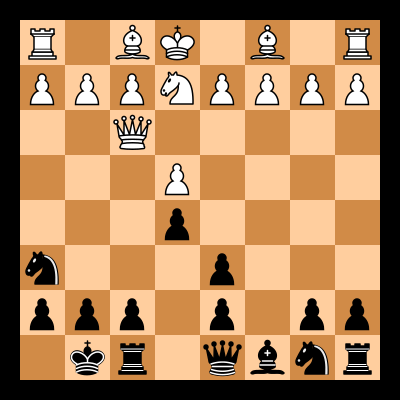





number moves: 11


In [ ]:
play()                    # play the game